In [1]:
from utils import *

In [2]:
#definition of constant
N = 1000 #number of sample
np.random.seed(0) #for reproductivity

# Example of posterior distributions

In [3]:
#constant of the inverse problem
A = np.eye(2)  #np.array([[2,0],[0,1]])
In = np.eye(2)
sigma = 1 #the noise level represent sigma^2

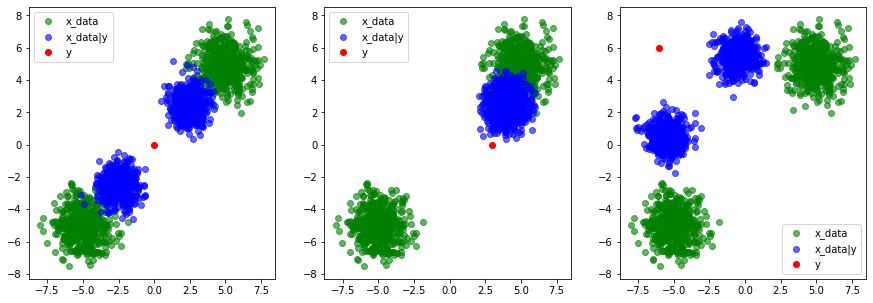

In [4]:
name = 'symetric_gaussians' #'symetric_gaussians', 'disymmetric_gaussians', 'cross'
mu_list, sigma_list, pi_list = gaussian_mixt_example(name)

sample_prior = sample_gaussian(mu_list, sigma_list, pi_list, N)

Y = [np.array([0,0]), np.array([3,0]), np.array([-6,6])] #observation
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    sample_post = sample_posterior(A, Y[i], sigma, N, mu_list, sigma_list, pi_list)

    ax[i].scatter(sample_prior[:, 0], sample_prior[:, 1], alpha=0.6, c='g')
    ax[i].scatter(sample_post[:,0], sample_post[:,1], alpha=0.6, c='b')
    ax[i].grid(False)
    ax[i].plot(Y[i][0],Y[i][1], 'ro')
    ax[i].legend(['x_data', 'x_data|y', 'y'])

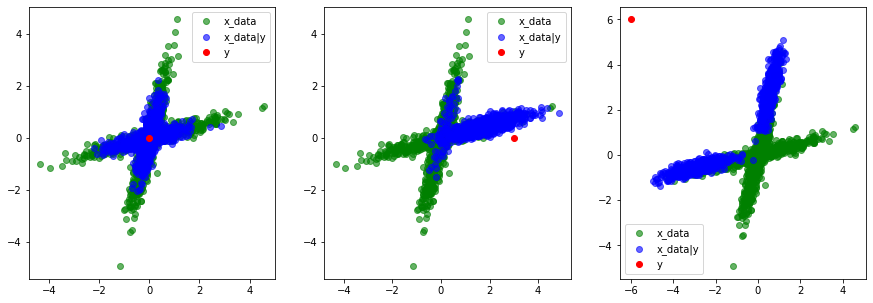

In [5]:
name = 'cross' #'symetric_gaussians', 'disymmetric_gaussians', 'cross'
mu_list, sigma_list, pi_list = gaussian_mixt_example(name)

sample_prior = sample_gaussian(mu_list, sigma_list, pi_list, N)

Y = [np.array([0,0]), np.array([3,0]), np.array([-6,6])] #observation
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    sample_post = sample_posterior(A, Y[i], sigma, N, mu_list, sigma_list, pi_list)

    ax[i].scatter(sample_prior[:, 0], sample_prior[:, 1], alpha=0.6, c='g')
    ax[i].scatter(sample_post[:,0], sample_post[:,1], alpha=0.6, c='b')
    ax[i].grid(False)
    ax[i].plot(Y[i][0],Y[i][1], 'ro')
    ax[i].legend(['x_data', 'x_data|y', 'y'])

## The $\sigma$ impact on the posterior distribution

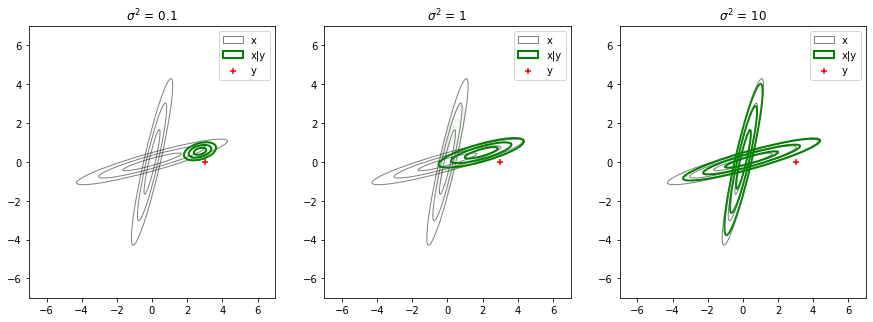

In [6]:
name = 'cross' #'symetric_gaussians', 'disymmetric_gaussians', 'cross'
mu_list, sigma_list, pi_list = gaussian_mixt_example(name)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
y = np.array([3,0])
Sigma = [0.1, 1, 10]
rbox = 4
for i in range(3):
    ax2 = ax[i]
    sigma = Sigma[i]
    mu_cond_list, sigma_cond_list, p_list = constantes_conditionnal_prob(A, y, sigma, mu_list, sigma_list, pi_list)

    alpha_list = Alpha(pi_list)
    alpha_list_2 = Alpha(p_list)
    
    draw_gaussian_mixture(ax2, mu_list, sigma_list, 0.5*alpha_list, rbox = rbox, color = 'k',  label = 'x')
    draw_gaussian_mixture(ax2, mu_cond_list, sigma_cond_list, alpha_list_2, rbox = rbox, color = 'g',  label = 'x|y', linewidth = 2)
    ax2.scatter(y[0], y[1], c = 'r', marker= '+', label = 'y')

    ax2.set_title('$\sigma^2$ = {}'.format(sigma))
    ax2.legend()
    ax2.set_xlim(-7, 7)
    ax2.set_ylim(-7, 7)

# plt.suptitle("Prior and posterior distribution for A = Id and sigma = {}".format(sigma))
plt.show()

# PnP-ULA
First we implement the algorithm then we test it.

In [7]:
def PnP_ULA(N, x_0, y, delta, A, sigma, MMSE_denoiser, epsilon, alpha):
    """
    Run PnP-ULA with N iterations, x_0 as initialization, y as an observation, A and sigma constant of the inverse problem,
    delta as a step size and MMSE_denoiser as a denoiser of level epsilon. alpha is the regularization parameter.
    """
    n = y.shape[0] #dimension of the observation, here n = 2
    X = [x_0] #list of the sample
    
    def score_data_fidelity(y,x,A,sigma):
        return A.T@(y-A@x)/sigma**2
    
    for i in tqdm(range(N-1)):
        x_k = X[-1]
        z_k1 = np.random.randn(n)
        x_k1 = x_k + delta * score_data_fidelity(y,x_k,A,sigma) + alpha*delta*(1/epsilon)*(MMSE_denoiser(x_k)-x_k) + np.sqrt(2*delta)*z_k1
        X.append(x_k1)
    X = np.array(X)
    return X

In [8]:
#first test - constant definition
name = 'symetric_gaussians' #'symetric_gaussians', 'disymmetric_gaussians', 'cross'
mu_list, sigma_list, pi_list = gaussian_mixt_example(name)
A = np.eye(2)  #np.array([[2,0],[0,1]])
In = np.eye(2)
sigma = 1 #the noise level represent sigma^2
epsilon = 1
MMSE_denoiser = Theorical_MMSE(epsilon, mu_list, sigma_list, pi_list)
delta = 0.5
alpha = 1.5
N = 10000
Y = [np.array([0,0]), np.array([3,0]), np.array([-6,6])] #observation
np.random.seed(42) #for reproductivity

In [9]:
Sample_ULA = []
for i in range(3):
    Sample_ULA.append(PnP_ULA(N, Y[i], Y[i], delta, A, sigma, MMSE_denoiser, epsilon, alpha))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:01<00:00, 6670.26it/s]


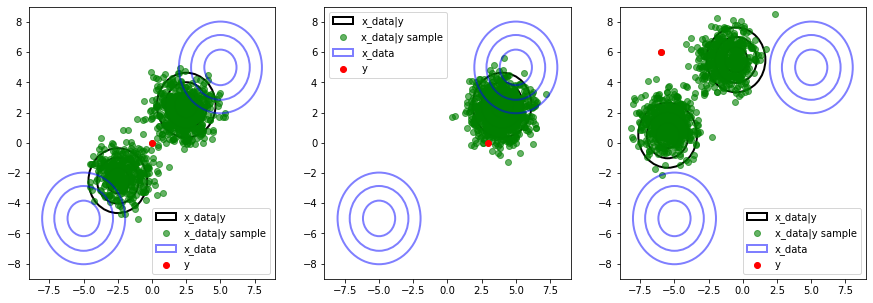

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    ax2 = ax[i]
    sample_ULA = Sample_ULA[i]
    sample_ULA = np.random.permutation(sample_ULA)[:1000] #take a sample of 1000 points
    y = Y[i]
    mu_cond_list, sigma_cond_list, p_list = constantes_conditionnal_prob(A, y, sigma, mu_list, sigma_list, pi_list)
    alpha_list = Alpha(p_list)
    draw_gaussian_mixture(ax2, mu_cond_list, sigma_cond_list, alpha_list, rbox = 5, color = 'k',  label = 'x_data|y', linewidth = 2)
    ax2.scatter(sample_ULA[:, 0], sample_ULA[:, 1], alpha=0.6, c='g', label = 'x_data|y sample') #sample of PnP-ULA
    draw_gaussian_mixture(ax2, mu_list, sigma_list, pi_list, rbox = 9, color = 'b',  label = 'x_data', linewidth = 2)
    ax2.scatter(y[0], y[1], c='r', label = 'y')
    ax2.grid(False)
    ax2.legend()

(-9.0, 9.0, -9.0, 9.0)

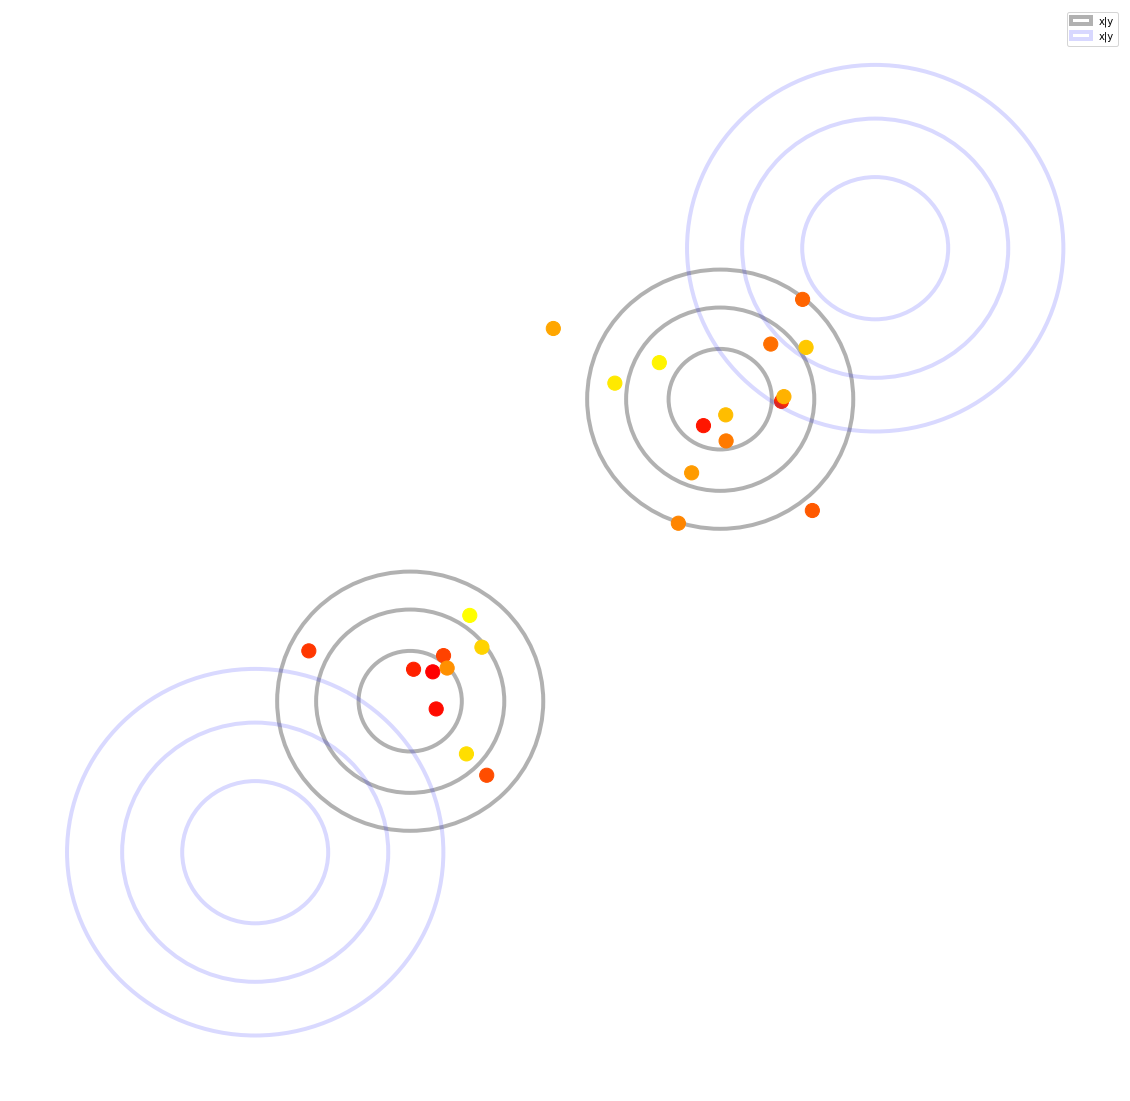

In [111]:
#For the first page of the dissertation

sample_ULA = Sample_ULA[0]
indices = np.arange(0,10000,400)
X = sample_ULA[indices]

fig, ax = plt.subplots(1, 1, figsize=(20, 20))

y = Y[0]
mu_cond_list, sigma_cond_list, p_list = constantes_conditionnal_prob(A, y, sigma, mu_list, sigma_list, pi_list)
alpha_list = Alpha(p_list)
draw_gaussian_mixture(ax, mu_cond_list, sigma_cond_list, 0.3*alpha_list, rbox = 5, color = 'k', linewidth = 4)
ax.scatter(X[1:, 0], X[1:, 1], s = 200, c=np.arange(len(X)-1), cmap='autumn') #sample of PnP-ULA

pi_list = np.array(pi_list)
draw_gaussian_mixture(ax, mu_list, sigma_list, 0.3*pi_list, rbox = 9, color = 'b', linewidth = 4)
# ax.scatter(y[0], y[1], c='r')
ax.grid(False)

# for i in range(len(X)-1):
#     plt.annotate('', xy=(X[i+1][0], X[i+1][1]), xytext=(X[i][0], X[i][1]),
#              arrowprops=dict(arrowstyle='->, head_width=0.3', color='g', linewidth=3, linestyle = '--',alpha = 0.5))
#     plt.plot([X[i][0], X[i+1][0]], [X[i][1], X[i+1][1]], color = 'g')
ax.axis(False)

## Influence of $N$ - convergence time

In [67]:
#first test - constant definition
name = 'symetric_gaussians' #'symetric_gaussians', 'disymmetric_gaussians', 'cross'
mu_list, sigma_list, pi_list = gaussian_mixt_example(name)
A = np.eye(2)  #np.array([[2,0],[0,1]])
In = np.eye(2)
sigma = 1 #the noise level represent sigma^2
epsilon = 1
MMSE_denoiser = Theorical_MMSE(epsilon, mu_list, sigma_list, pi_list)
delta = 0.5
alpha = 1.5
N = 100000
y = np.array([0,0])
x_0 = y
np.random.seed(42) #for reproductivity

In [68]:
sample_ULA = PnP_ULA(N, y, y, delta, A, sigma, MMSE_denoiser, epsilon, alpha)

100%|██████████████████████████████████████████████████████████████████████████| 99999/99999 [00:10<00:00, 9553.93it/s]


In [69]:
N_list = [1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,3000,4000,5000,10000,15000,20000,30000,50000,80000,100000]
Wass_dist = []
sample_post = sample_posterior(A, y, sigma, 100000, mu_list, sigma_list, pi_list) #take a sample of the posterior
for n in tqdm(N_list):
    s_ULA = sample_ULA[:n]
    Wass_dist.append(Wasserstein_distance(sample_post, s_ULA))

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  5.33it/s]


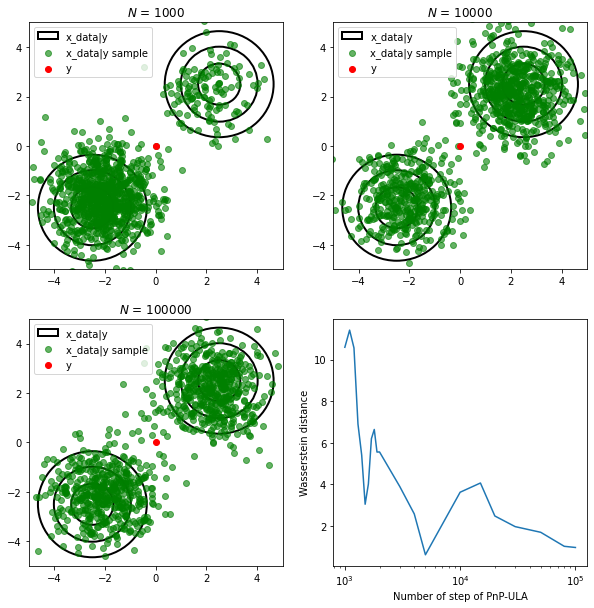

In [70]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
n_list = [1000,10000,100000]
ind = [(0,0),(0,1),(1,0)]
for i in range(3):
    ax2 = ax[ind[i]]
    n = n_list[i]
    s_ULA = np.random.permutation(sample_ULA[:n])[:1000] #take a sample of 1000 points
    mu_cond_list, sigma_cond_list, p_list = constantes_conditionnal_prob(A, y, sigma, mu_list, sigma_list, pi_list)
    alpha_list = Alpha(p_list)
    draw_gaussian_mixture(ax2, mu_cond_list, sigma_cond_list, alpha_list, rbox = 5, color = 'k',  label = 'x_data|y', linewidth = 2)
    ax2.scatter(s_ULA[:, 0], s_ULA[:, 1], alpha=0.6, c='g', label = 'x_data|y sample') #sample of PnP-ULA
    ax2.scatter(y[0], y[1], c='r', label = 'y')
    ax2.grid(False)
    ax2.legend()
    ax2.set_title('$N$ = {}'.format(n))

ax2 = ax[1,1]
ax2.set_xlabel('Number of step of PnP-ULA')
ax2.set_ylabel('Wasserstein distance')
ax2.semilogx(N_list,Wass_dist)

## Influence of $\alpha$ - temperature

In [25]:
#first test - constant definition
name = 'symetric_gaussians' #'symetric_gaussians', 'disymmetric_gaussians', 'cross'
mu_list, sigma_list, pi_list = gaussian_mixt_example(name)
A = np.eye(2)  #np.array([[2,0],[0,1]])
In = np.eye(2)
sigma = 1 #the noise level represent sigma^2
epsilon = 1
MMSE_denoiser = Theorical_MMSE(epsilon, mu_list, sigma_list, pi_list)
delta = 0.5
N = 10000
y = np.array([0,0])
x_0 = y
np.random.seed(42) #for reproductivity

In [26]:
Alpha_list = [i*0.2 for i in range(21)]
Sample_ULA = []
for alpha in Alpha_list:
    Sample_ULA.append(PnP_ULA(N, x_0, y, delta, A, sigma, MMSE_denoiser, epsilon, alpha))

100%|████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:01<00:00, 8856.32it/s]


In [27]:
Wass_dist = []
sample_post = sample_posterior(A, y, sigma, 100000, mu_list, sigma_list, pi_list) #take a sample of the posterior
for i in tqdm(range(len(Alpha_list))):
    s_ULA = Sample_ULA[i]
    Wass_dist.append(Wasserstein_distance(sample_post, s_ULA))

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.94it/s]


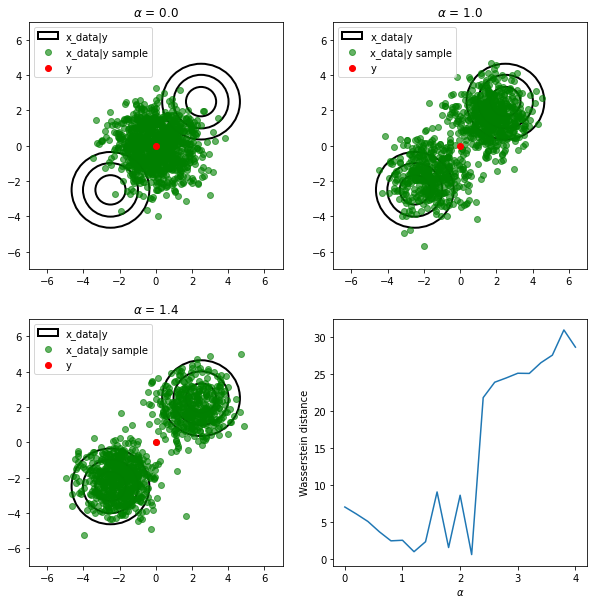

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ind = [0,5,7]
ind2 = [(0,0),(0,1),(1,0)]
for i in range(3):
    ax2 = ax[ind2[i]]
    alpha = Alpha_list[ind[i]]
    sample_ULA = Sample_ULA[ind[i]]
    s_ULA = np.random.permutation(sample_ULA)[:1000] #take a sample of 1000 points
    mu_cond_list, sigma_cond_list, p_list = constantes_conditionnal_prob(A, y, sigma, mu_list, sigma_list, pi_list)
    alpha_list = Alpha(p_list)
    draw_gaussian_mixture(ax2, mu_cond_list, sigma_cond_list, alpha_list, rbox = 7, color = 'k',  label = 'x_data|y', linewidth = 2)
    ax2.scatter(s_ULA[:, 0], s_ULA[:, 1], alpha=0.6, c='g', label = 'x_data|y sample') #sample of PnP-ULA
    ax2.scatter(y[0], y[1], c='r', label = 'y')
    ax2.grid(False)
    ax2.legend()
    ax2.set_title(r'$\alpha$ = {:.1f}'.format(alpha))

ax2 = ax[1,1]
ax2.set_xlabel(r'$\alpha$')
ax2.set_ylabel('Wasserstein distance')
ax2.plot(Alpha_list,Wass_dist)

## Influence of $\epsilon$ - denoiser parameter

In [30]:
#first test - constant definition
name = 'symetric_gaussians' #'symetric_gaussians', 'disymmetric_gaussians', 'cross'
mu_list, sigma_list, pi_list = gaussian_mixt_example(name)
A = np.eye(2)  #np.array([[2,0],[0,1]])
In = np.eye(2)
sigma = 1 #the noise level represent sigma^2
delta = 0.5
alpha = 1.5
N = 10000
y = np.array([0,0])
x_0 = y
np.random.seed(42) #for reproductivity

In [31]:
Epsilon_list = [0.5,1,3,5,7,10,20,30,40,50,80,100]
Sample_ULA = []
for epsilon in Epsilon_list:
    MMSE_denoiser = Theorical_MMSE(epsilon, mu_list, sigma_list, pi_list)
    Sample_ULA.append(PnP_ULA(N, x_0, y, delta, A, sigma, MMSE_denoiser, epsilon, alpha))

100%|████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:01<00:00, 9472.18it/s]


In [32]:
Wass_dist = []
sample_post = sample_posterior(A, y, sigma, 100000, mu_list, sigma_list, pi_list) #take a sample of the posterior
for i in tqdm(range(len(Epsilon_list))):
    s_ULA = Sample_ULA[i]
    Wass_dist.append(Wasserstein_distance(sample_post, s_ULA))

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.74it/s]


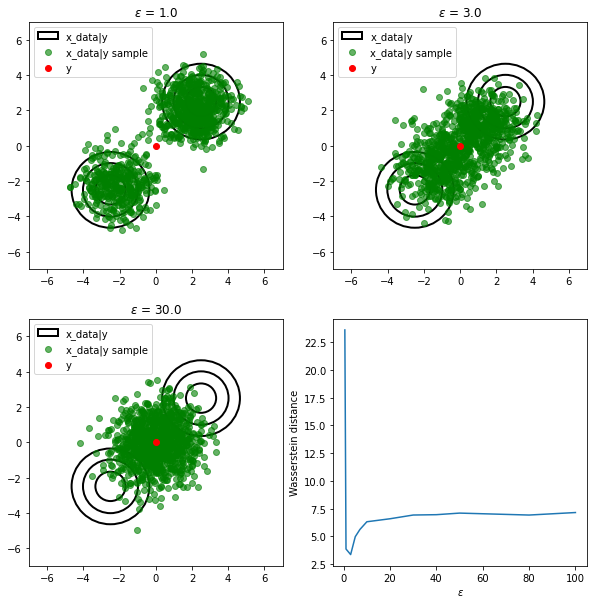

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ind = [1,2,7]
ind2 = [(0,0),(0,1),(1,0)]
for i in range(3):
    ax2 = ax[ind2[i]]
    epsilon = Epsilon_list[ind[i]]
    sample_ULA = Sample_ULA[ind[i]]
    s_ULA = np.random.permutation(sample_ULA)[:1000] #take a sample of 1000 points
    mu_cond_list, sigma_cond_list, p_list = constantes_conditionnal_prob(A, y, sigma, mu_list, sigma_list, pi_list)
    alpha_list = Alpha(p_list)
    draw_gaussian_mixture(ax2, mu_cond_list, sigma_cond_list, alpha_list, rbox = 7, color = 'k',  label = 'x_data|y', linewidth = 2)
    ax2.scatter(s_ULA[:, 0], s_ULA[:, 1], alpha=0.6, c='g', label = 'x_data|y sample') #sample of PnP-ULA
    ax2.scatter(y[0], y[1], c='r', label = 'y')
    ax2.grid(False)
    ax2.legend()
    ax2.set_title(r'$\epsilon$ = {:.1f}'.format(epsilon))

ax2 = ax[1,1]
ax2.set_xlabel(r'$\epsilon$')
ax2.set_ylabel('Wasserstein distance')
ax2.plot(Epsilon_list,Wass_dist)

## Influence of $\delta$ - step size

In [35]:
#first test - constant definition
name = 'symetric_gaussians' #'symetric_gaussians', 'disymmetric_gaussians', 'cross'
mu_list, sigma_list, pi_list = gaussian_mixt_example(name)
A = np.eye(2)  #np.array([[2,0],[0,1]])
In = np.eye(2)
sigma = 1 #the noise level represent sigma^2
alpha = 1.5
epsilon = 1.0
N = 10000
y = np.array([0,0])
x_0 = y
np.random.seed(42) #for reproductivity

In [36]:
Delta_list = [0.00001,0.0001,0.001,0.01,0.1, 0.5]
Sample_ULA = []
for delta in Delta_list:
    MMSE_denoiser = Theorical_MMSE(epsilon, mu_list, sigma_list, pi_list)
    Sample_ULA.append(PnP_ULA(N, x_0, y, delta, A, sigma, MMSE_denoiser, epsilon, alpha))

100%|████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:03<00:00, 2983.30it/s]


In [37]:
Wass_dist = []
sample_post = sample_posterior(A, y, sigma, 100000, mu_list, sigma_list, pi_list) #take a sample of the posterior
for i in tqdm(range(len(Delta_list))):
    s_ULA = Sample_ULA[i]
    Wass_dist.append(Wasserstein_distance(sample_post, s_ULA))

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.27it/s]


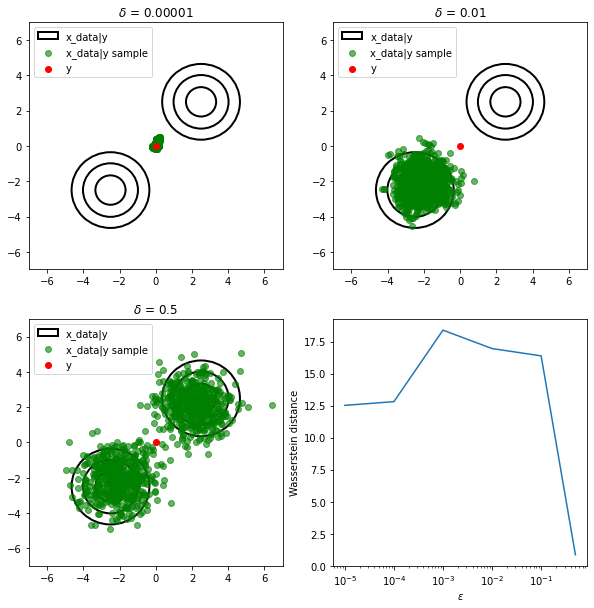

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ind = [0,3,5]
ind2 = [(0,0),(0,1),(1,0)]
title = ['$\delta$ = 0.00001', '$\delta$ = 0.01', '$\delta$ = 0.5']
for i in range(3):
    ax2 = ax[ind2[i]]
    delta = Delta_list[ind[i]]
    sample_ULA = Sample_ULA[ind[i]]
    s_ULA = np.random.permutation(sample_ULA)[:1000] #take a sample of 1000 points
    mu_cond_list, sigma_cond_list, p_list = constantes_conditionnal_prob(A, y, sigma, mu_list, sigma_list, pi_list)
    alpha_list = Alpha(p_list)
    draw_gaussian_mixture(ax2, mu_cond_list, sigma_cond_list, alpha_list, rbox = 7, color = 'k',  label = 'x_data|y', linewidth = 2)
    ax2.scatter(s_ULA[:, 0], s_ULA[:, 1], alpha=0.6, c='g', label = 'x_data|y sample') #sample of PnP-ULA
    ax2.scatter(y[0], y[1], c='r', label = 'y')
    ax2.grid(False)
    ax2.legend()
    ax2.set_title(title[i])

ax2 = ax[1,1]
ax2.set_xlabel(r'$\epsilon$')
ax2.set_ylabel('Wasserstein distance')
ax2.semilogx(Delta_list,Wass_dist)

# Denoiser Mismatch

In [102]:
#first test - constant definition
name = 'cross' #'symetric_gaussians', 'disymmetric_gaussians', 'cross'
mu_list, sigma_list, pi_list = gaussian_mixt_example(name)
A = np.eye(2)  #np.array([[2,0],[0,1]])
In = np.eye(2)
sigma = 1 #the noise level represent sigma^2
alpha = 0.3
epsilon = 0.05
delta = 0.05
N = 100000
y = np.array([0,8])
x_0 = np.array([0,0])
np.random.seed(42) #for reproductivity

In [103]:
def Denoiser_cut(epsilon, mu_list, sigma_list, pi_list, cut = -2):
    """
    A function to create a denoiser which have the same behaviour than the perfect denoiser 
    on half of the space and map to zero on the other half of the 2D space.
    """
    denoiser_th = Theorical_MMSE(epsilon, mu_list, sigma_list, pi_list)
    def denoiser_cut(x):
        if x[0]>cut:
            return denoiser_th(x)
        else:
            return np.zeros(2)
    return denoiser_cut

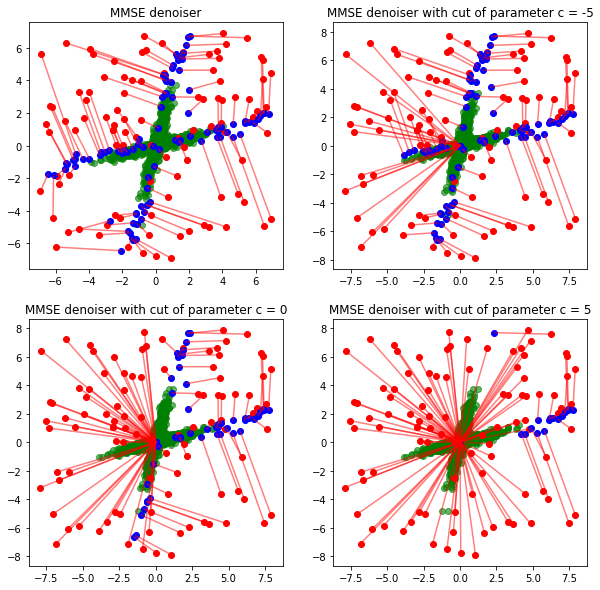

In [112]:
#show some examples of cut denoiser
Cut = [-5,0,5]
fig, ax = plt.subplots(2, 2, figsize = (10,10))

prior_data = sample_gaussian(mu_list, sigma_list, pi_list, 1000)

denoiser_th = Theorical_MMSE(epsilon, mu_list, sigma_list, pi_list)
denoiser_map(ax[0,0], denoiser_th, prior_data, xmin = -7, xmax = 7, ymin = -7, ymax = 7, npts = 100, seed = 1234)
ax[0,0].set_title('MMSE denoiser')

indice = [(0,1),(1,0),(1,1)]
for i, cut in enumerate(Cut):
    denoiser_cut = create_denoiser_cut(epsilon, mu_list, sigma_list, pi_list, cut = cut)
    denoiser_map(ax[indice[i]], denoiser_cut, prior_data, xmin = -8, xmax = 8, ymin = -8, ymax = 8)
    ax[indice[i]].set_title("MMSE denoiser with cut of parameter c = {}".format(cut))

In [105]:
#for multiple cut indices
X_list = []
den_list = []

MMSE_den = Theorical_MMSE(epsilon, mu_list, sigma_list, pi_list)
den_list.append(MMSE_den)
X = PnP_ULA(N, x_0, y, delta, A, sigma, MMSE_den, epsilon, alpha)
X_list.append(X)

Cut = np.linspace(-2,2,50)
r = len(Cut)+1

for cut in Cut:
    denoiser_cut = create_denoiser_cut(epsilon, mu_list, sigma_list, pi_list, cut = cut)
    den_list.append(denoiser_cut)
    X = PnP_ULA(N, x_0, y, delta, A, sigma, denoiser_cut, epsilon, alpha)
    X_list.append(X)

100%|█████████████████████████████████████████████████████████████████████████| 99999/99999 [00:01<00:00, 59294.25it/s]


In [106]:
#compute the difference with respect with the prior
dist_l2_prior = np.zeros(r)

N1 = len(prior_data)

for i in tqdm(range(1,r)):
    distance1 = 0
    for x in prior_data:
        distance1 += np.sum((den_list[0](x) - den_list[i](x))**2)
    dist_l2_prior[i-1] = np.sqrt(distance1 / N1)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.93it/s]


In [107]:
#estimation of the posterior L2 distance between denoisers
dist_l2_posterior = np.zeros(r)

N1 = 1000

for i in tqdm(range(1,r)):
    X = X_list[0]
    X_sample = np.random.permutation(X)[:N1]
    distance1 = 0
    for x in X_sample:
        distance1 += np.sum((den_list[0](x) - den_list[i](x))**2)
    dist_l2_posterior[i-1] = np.sqrt(distance1 / N1)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.48it/s]


In [108]:
#computation of the Wasserstein distance between sampling
Dist_wass = []

X_0 = X_list[0]
indices = np.random.randint(0, N, size = 1000)
X_0_s = X_0[indices,:]

for i in tqdm(range(1,r)):
    indices = np.random.randint(0, N, size = 1000)
    X_sample = X_list[i][indices, :]
    M = ot.dist(X_sample, X_0_s)
    dist = ot.emd2(a = [], b = [], M = M)
    Dist_wass.append(dist)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.95it/s]


In [109]:
def correlation(u,v):
    return np.mean((u-np.mean(u))*(v-np.mean(v)))/(np.std(u) * np.std(v))

print('Correlation between Wasserstein distance and posterior L2 distance',correlation(Dist_wass,dist_l2_posterior[:-1]))
print('Correlation between Wasserstein distance and prior L2 distance',correlation(Dist_wass,dist_l2_prior[:-1]))

Correlation between Wasserstein distance and posterior L2 distance 0.9549739619533992
Correlation between Wasserstein distance and prior L2 distance 0.8960613425067697


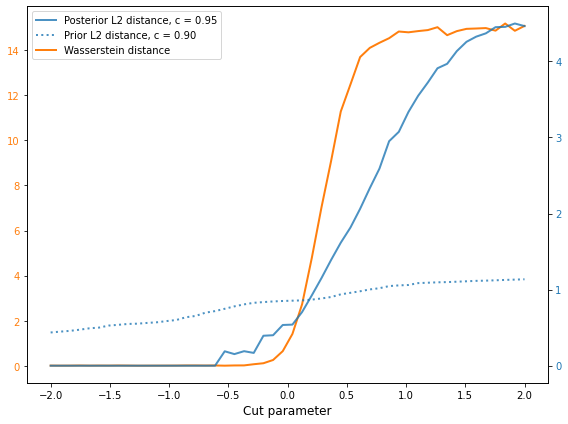

In [110]:
fig, ax1 = plt.subplots(figsize=(8, 6))

color = 'tab:orange'
ax1.plot(Cut, Dist_wass, color=color, alpha=1, linewidth=2, label = 'Wasserstein distance') 
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
corr_dist1 = correlation(Dist_wass, dist_l2_posterior[:-1])
corr_distl2 = correlation(Dist_wass, dist_l2_prior[:-1])

ax2.plot(Cut, dist_l2_posterior[:-1], color=color, label='Posterior L2 distance, c = {:.2f}'.format(corr_dist1), alpha=0.8, linewidth=2)
ax2.plot(Cut, dist_l2_prior[:-1], color=color, label='Prior L2 distance, c = {:.2f}'.format(corr_distl2), alpha=0.8, linewidth=2, linestyle='dotted')

ax2.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('Cut parameter', fontsize=12)

# Adjusting layout
fig.tight_layout()

# Add legend
lines, labels = ax2.get_legend_handles_labels()
lines += ax1.get_legend_handles_labels()[0]
labels += ax1.get_legend_handles_labels()[1]
plt.legend(lines, labels, loc='upper left', fontsize=10)

plt.show()

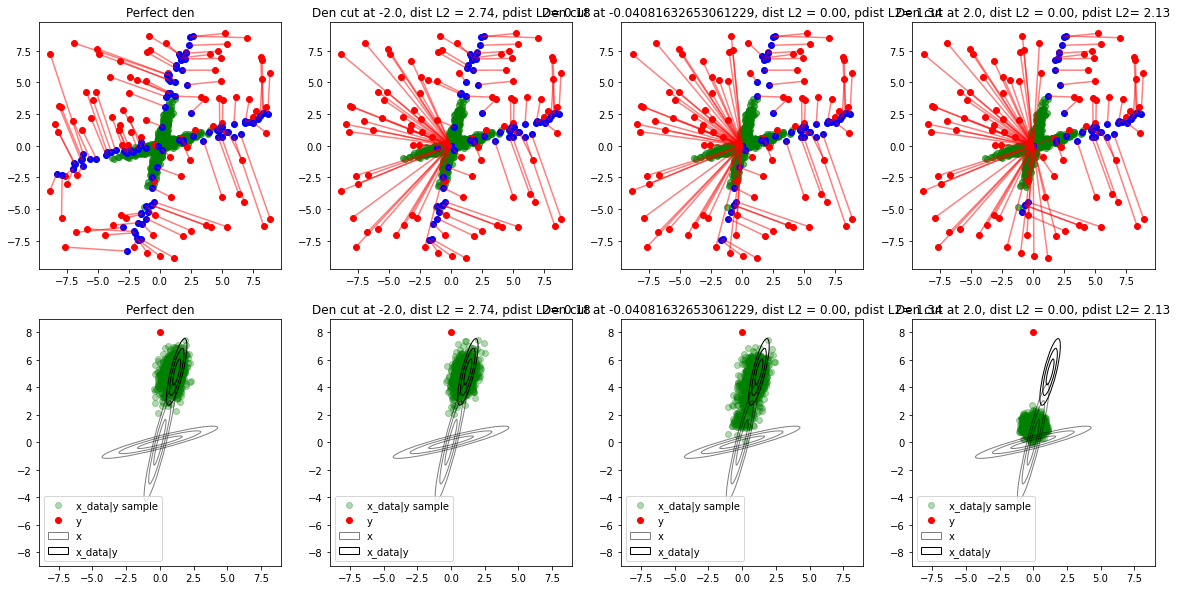

In [119]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

Cut = np.linspace(-2,2,50)
r_box = 9
Title = ['Perfect den']
indices = [0,1,25,50]
for i in range(1,4):
    Title.append('Den cut at {}, dist L2 = {:.2f}, pdist L2= {:.2f}'.format(Cut[indices[i]-1], dist_l2[indices[i]-1], dist_1[indices[i]-1])) 

for i in range(4):
    axi = ax[0,i]
    denoiser_map(axi, den_list[indices[i]], prior_data, xmin = -r_box, xmax = r_box, ymin = -r_box, ymax = r_box)
    axi.set_title(Title[i])

for i in range(4):
    X = X_list[indices[i]]
    axi = ax[1,i]
    X_sample = np.random.permutation(X)[:1000]
    axi.scatter(X_sample[:, 0], X_sample[:, 1], alpha=0.3, c='g', label = 'x_data|y sample')
    axi.plot(y[0],y[1], 'ro', label = 'y')

    mu_cond_list, sigma_cond_list, p_list = constantes_conditionnal_prob(A, y, sigma, mu_list, sigma_list, pi_list)
    alpha_list= Alpha(pi_list)
    alpha1_list= Alpha(p_list)
    draw_gaussian_mixture(axi, mu_list, sigma_list, 0.5*alpha_list, rbox = rbox, color = 'k',  label = 'x')
    draw_gaussian_mixture(axi, mu_list = mu_cond_list, sigma_list = sigma_cond_list, rbox = rbox, color = 'k', alpha_list = alpha1_list, label = 'x_data|y')
    axi.set_title(Title[i])
    axi.set_xlim(-r_box, r_box)
    axi.set_ylim(-r_box, r_box)

plt.show()